<a href="https://colab.research.google.com/github/yovelop/NN/blob/master/NN_Energy_Predictor_0.31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
DIR = '/content/drive/My Drive/Colab Notebooks/ENSaver/'
DIR_SAVE = '/content/drive/My Drive/Colab Notebooks/ENSaver/31/'
#drive.flush_and_unmount()

Mounted at /content/drive


In [0]:
#Импорты
  import numpy as np # linear algebra
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
  import gc

  import matplotlib.pyplot as plt
  import matplotlib.style
  matplotlib.style.use('ggplot')

  from sys import getsizeof

  import os
  for dirname, _, filenames in os.walk(DIR):
      for filename in filenames:
          print(os.path.join(dirname, filename))

  pd.options.mode.chained_assignment = None  # default='warn'
  import warnings
  pd.set_option('display.max_rows', 500)
  pd.set_option('display.max_columns', 500)
  pd.set_option('display.width', 100)
  warnings.filterwarnings('ignore')
  np.set_printoptions(precision = 3, suppress  = True)
  pd.set_option('display.float_format', lambda x: '%.3f' % x)

  def reduce_mem_usage(df, verbose = False):
      start_mem_usg = df.memory_usage().sum() / 1024**2 
      print("Memory usage of properties dataframe is :",start_mem_usg," MB")
      NAlist = [] # Keeps track of columns that have missing values filled in. 
      for col in df.columns:
          if (df[col].dtype != object) &  (df[col].dtype != 'datetime64[ns]'):  # Exclude strings            
              # Print current column type
              if verbose:  
                print("******************************")
                print("Column: ",col)
                print("dtype before: ",df[col].dtype)            
              # make variables for Int, max and min
              IsInt = False
              mx = df[col].max()
              mn = df[col].min()
              if verbose:
                print("min for this col: ",mn)
                print("max for this col: ",mx)
              # Integer does not support NA, therefore, NA needs to be filled
              if not np.isfinite(df[col]).all(): 
                  NAlist.append(col)
                  df[col].fillna(mn-1,inplace=True)  
                    
              # test if column can be converted to an integer
              asint = df[col].fillna(0).astype(np.int64)
              result = abs(df[col] - asint)
              result = result.sum()
              if result > -0.01 and result < 0.01:
                  IsInt = True            
              # Make Integer/unsigned Integer datatypes
              if IsInt:
                  if mn >= 0:
                      if mx < 255:
                          df[col] = df[col].astype(np.uint8)
                      elif mx < 65535:
                          df[col] = df[col].astype(np.uint16)
                      elif mx < 4294967295:
                          df[col] = df[col].astype(np.uint32)
                      else:
                          df[col] = df[col].astype(np.uint64)
                  else:
                      if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                          df[col] = df[col].astype(np.int8)
                      elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                          df[col] = df[col].astype(np.int16)
                      elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                          df[col] = df[col].astype(np.int32)
                      elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                          df[col] = df[col].astype(np.int64)    
              # Make float datatypes 32 bit
              else:
                  df[col] = df[col].astype(np.float32)
              
              # Print new column type
              if verbose:
                print("dtype after: ",df[col].dtype)
                print("******************************")
      # Print final result
      print("___MEMORY USAGE AFTER COMPLETION:___")
      mem_usg = df.memory_usage().sum() / 1024**2 
      print("Memory usage is: ",mem_usg," MB")
      print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
      return df, NAlist

  def show_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Val'])
    plt.show()
    
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1,2])
    plt.legend(['Train','Val'])
    plt.show()

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0,1])
    plt.legend(['Train','Val'])
    plt.show()

  #Импорты Керас:
  from keras.models import Sequential, load_model

  from keras.layers import Dense
  from keras.initializers import TruncatedNormal, Constant
  from keras.regularizers import l1,l2,l1_l2
  from keras.optimizers import Adam
  import keras.backend as K

  from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
  #from keras.utils import plot_model
  from keras.losses import mean_squared_error as mse #, mean_absolute_percentage_error as mape

  def RMSLE(y_true, y_pred):
    return K.pow( K.mean( K.pow(K.log(y_true+1) - K.log(y_pred+1),2.00000)),0.5000)

  def MSLE(y_true, y_pred):
    return K.mean( K.pow(K.log(y_true+1) - K.log(y_pred+1),2.00000))

  def MALE(y_true, y_pred):
    return K.mean( K.abs(K.log(y_true+1) - K.log(y_pred+1)))

  def tweedieloss(y_true, y_pred):
      return K.mean(  K.pow(    K.pow(backend.maximum(0.000,K.maximum(0.013000,y_true)),0.5)  -   K.pow(K.maximum(0.013000,y_pred),0.5)   , 2 ) / K.pow(K.maximum(0.013000,y_pred),0.5)
                  )

  def tweedieloss_bkp(y_true, y_pred):
      p=1.5
      dev = 2 * (K.pow(K.maximum(0.000,y_true), 2-p)/((1-p) * (2-p)) -
                    y_true * K.pow(y_pred, 1-p)/(1-p) +
                    K.pow(y_pred, 2-p)/(2-p))
      return K.mean(dev)

  def VAL_ (y_true, y_pred):
      return  K.maximum(0.0330000, K.sum(y_pred))/ K.maximum(0.033000, K.sum(y_true)) 
      
  def VAL_2 (y_true, y_pred):
      return  K.minimum( 5.000000, K.exp ( K.abs( K.log( VAL_ (y_true, y_pred))))-1)
  
  def VAL_3 (y_true, y_pred):
      return  K.exp ( K.abs( K.log( VAL_ (y_true, y_pred))))-1

  def MAPE_ (y_true, y_pred):
      return K.mean( K.minimum( 5.000000,  K.abs(y_true - y_pred)/ K.maximum(0.033000, y_true)) )
      
  def MAE_(y_true, y_pred):
      return K.sum( K.abs(y_true - y_pred))/ K.maximum(0.033000, K.sum(y_true))

  def MSE_(y_true, y_pred):
      return K.sum( K.pow(y_true - y_pred,2.00000))/ K.maximum(0.033000,  K.sum(K.pow(y_true,2.00000)))

  def MAE_MAPE(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          +  0.250000 * MAPE_ (y_true, y_pred)
      )
              
  def MAE_VAL_MAPE(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          + 1.800000 *   VAL_2 (y_true, y_pred)          
          + 0.950000 *   MAPE_ (y_true, y_pred)
          )

  def MAE_VAL(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          + 0.800000 *   VAL_2 (y_true, y_pred)                     
              )

  def MAPE_VAL(y_true, y_pred):
      return (
                      MAPE_ (y_true, y_pred)
          + 0.4000 *  VAL_2 (y_true, y_pred)             
              )

  def MSE_VAL_MAPE(y_true, y_pred):
      return (
            5.000000 *   MSE_(y_true, y_pred)
          + 2.200000 *   VAL_2 (y_true, y_pred)          
          + 0.750000 *   MAPE_ (y_true, y_pred)
          )

  def MASPE_VAL(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)               
          + 0.500000 *   MSE_(y_true, y_pred)
          + 1.200000 *   VAL_2 (y_true, y_pred)          
          + 0.250000 *   MAPE_ (y_true, y_pred)
          )
  
  def MAE_RMSLE(y_true, y_pred):
      return (
            1.000000 *   MAE_   (y_true, y_pred)
          + 2.000000 *   RMSLE  (y_true, y_pred)          
          )  

  def MAPE_RMSLE(y_true, y_pred):
      return (
            1.000000 *   MAPE_   (y_true, y_pred)
          + 0.100000 *   RMSLE  (y_true, y_pred)          
          )  
  
  def MAPE_VAL_RMSLE(y_true, y_pred):
      return (
            1.000000 *   MAPE_   (y_true, y_pred)
          + 1.000000 *   RMSLE   (y_true, y_pred)    
          + 1.000000 *   VAL_2   (y_true, y_pred)      
          )  
 
  import keras.metrics
  keras.metrics.MAE_ = MAE_
  keras.metrics.VAL_ = VAL_
  keras.metrics.VAL_2 = VAL_2
  keras.metrics.MAPE_ = MAPE_
  keras.metrics.MSE_ = MSE_
  keras.metrics.tweedieloss = tweedieloss
  keras.metrics.MAE_RMSLE = MAE_RMSLE
  keras.metrics.MAPE_RMSLE = MAPE_RMSLE
  keras.metrics.MAPE_VAL_RMSLE = MAPE_VAL_RMSLE
  keras.metrics.RMSLE = RMSLE
  keras.metrics.MSLE = MSLE
  keras.metrics.MALE = MALE

  import keras.losses
  keras.losses.MAE_VAL_MAPE = MAE_VAL_MAPE
  keras.losses.MSE_VAL_MAPE = MSE_VAL_MAPE
  keras.losses.MAE_ = MAE_
  keras.losses.MASPE_VAL = MASPE_VAL
  keras.losses.tweedieloss = tweedieloss
  keras.losses.MAE_RMSLE = MAE_RMSLE
  keras.losses.MAPE_RMSLE = MAPE_RMSLE
  keras.losses.MAPE_VAL_RMSLE = MAPE_VAL_RMSLE
  keras.losses.RMSLE = RMSLE
  keras.losses.MSLE = MSLE
  keras.losses.MALE = MALE

  class MyCustomCallback(keras.callbacks.Callback):
    
    def __init__(self, epochs, stats_print_step): 
        
        self.__epochs = epochs
        self.__stats_print_step = stats_print_step
    
    def on_train_begin(self, logs={}):
        pass
        #print('on_train_begin', logs)
 
    def on_train_end(self, logs={}):
        pass
        #print('on_train_end', logs)
 
    def on_epoch_begin(self, epoch, logs={}):
        pass
 
    def on_epoch_end(self, epoch, logs={}):
        if ((epoch < 5) or (epoch % self.__stats_print_step == 0)) :
            print('# ' + str('{:04d}'.format(epoch + 1)) + ' | ' + self.get_stats_by_epoch(logs))
        if epoch == 2:
            print('.......')
        if epoch == self.__epochs - 1:
            print('# ' + str('{:04d}'.format(epoch + 1)) + ' | ' + self.get_stats_by_epoch(logs))
        else:
            print('# ' + str('{:04d}'.format(epoch + 1)) + ' | ' + self.get_stats_by_epoch(logs), end="\r")
 
    def on_batch_begin(self, batch, logs={}):
        pass
        #print('on_batch_begin', batch, logs)
 
    def on_batch_end(self, batch, logs={}):
        pass
        #print('on_batch_end', batch, logs)

    def get_stats_by_epoch(self, logs):
        
        is_test = True
        s = ''
        
        for key, value in logs.items(): 
            if is_test:
                if 'val_' not in str(key):
                    s += ' /// '
                    is_test = False
            if is_test:
                s += ' ' + str(key).replace('val_', 'TST_') + ': ' + "{0:.4f}".format(value)
            else:
                s += ' ' + 'TRN_' + str(key) + ': ' + "{0:.4f}".format(value)

        return s #'val_loss: ' + "{0:.4f}".format(logs['val_loss']) + ' | loss: ' + "{0:.4f}".format(logs['loss'])

In [0]:
#0: electricity, 1: chilledwater, 2: steam, 3: hotwater
#  Подготовка данных
  df = pd.read_csv(DIR + "train.csv", engine = 'python')
  #df_test = pd.read_csv(DIR + "test.csv", engine = 'python')

  df['timestamp'] = pd.to_datetime(df['timestamp'])
  #df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

  #Очистка от корявых данных
  #df = df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

  #df['meter_reading'] = np.log1p(df['meter_reading'])

  #df = pd.concat([df_train, df_test], sort=False)

  df['hour_cos'] = np.cos(df['timestamp'].dt.hour * 2 * np.pi / 24)
  df['hour_sin'] = np.sin(df['timestamp'].dt.hour * 2 * np.pi / 24)

  df['weekday_cos'] = np.cos(df['timestamp'].dt.weekday * 2 * np.pi / 7)
  df['weekday_sin'] = np.sin(df['timestamp'].dt.weekday * 2 * np.pi / 7)

  df['week_cos'] = np.cos(df['timestamp'].dt.week * 2 * np.pi / 53)
  df['week_sin'] = np.sin(df['timestamp'].dt.week * 2 * np.pi / 53)

  #df_train['weekends'] = (df_train['weekday'] >= 6) * 1

In [0]:
#Очистка от подозрительных нулей
  #print(df[df['building_id']==2][['timestamp','meter_reading','meter','ds_zero','de_zero','is_bad_zero']].head(20))
  df = df.sort_values(by = ['meter','building_id','timestamp'])
  df['meter_reading_prev'] = 0

  #for bid in df['building_id'].unique():
  #  for met in df['meter'].unique():
  df['meter_reading_prev'] = df['meter_reading'].shift()
  df['is_equal_prev']= (df['meter_reading_prev'] == df['meter_reading'] )*1

  df['day'] = df['timestamp'].dt.dayofyear
  df_bad_rows = df.groupby(by=['building_id','day','meter'], as_index = False)['is_equal_prev'].mean()
  df_bad_rows.rename({"is_equal_prev": "IS_BAD_PRCNT"}, axis='columns', inplace=True)

  df = pd.merge(df, df_bad_rows, how = 'inner', on = ['building_id','day','meter'])
  #print(df_bad_rows[df_bad_rows['building_id']==109].head(365))
  del df_bad_rows 

  #print(df[df['building_id']==2][['timestamp','meter_reading','is_equal_prev','IS_BAD_PRCNT','day']].head(30))

In [5]:
# Добавление медианы по метрике постройки
  #df_tmp = df[df['IS_BAD_PRCNT']<0.45]
  df_median = df.groupby(by=['building_id','meter']) ['meter_reading'].median()
  df_median.name = 'building_meter_median'
  df_mean = df.groupby(by=['building_id','meter']) ['meter_reading'].mean()
  df_mean.name = 'building_meter_mean'
  df_median = pd.merge(df_median, df_mean, how = 'inner', on = ['building_id','meter'])
  df_median['building_meter_median'] = ( df_median['building_meter_median'] * 27.000 + df_median['building_meter_mean'])/28.000
  
  df_median2 = df[df['IS_BAD_PRCNT']<0.45].groupby(by=['building_id','meter']) ['meter_reading'].median()
  df_median2.name = 'building_meter_median_45'
  df_mean2 = df[df['IS_BAD_PRCNT']<0.45].groupby(by=['building_id','meter']) ['meter_reading'].mean()
  df_mean2.name = 'building_meter_mean_45'
  df_median2 = pd.merge(df_median2, df_mean2, how = 'inner', on = ['building_id','meter'])
  df_median2['building_meter_median_45'] = ( df_median2['building_meter_median_45'] * 27.000 + df_median2['building_meter_mean_45'])/28.000
  df_median = pd.merge(df_median, df_median2, how = 'left', on = ['building_id','meter'])

  df_median['building_meter_median'] = np.where(df_median['building_meter_median_45'] >= 0, df_median['building_meter_median_45'], df_median['building_meter_median'])
  df_median.drop(columns=['building_meter_median_45'], inplace = True)

  df = pd.merge(df, df_median, how = 'inner', on = ['building_id','meter'])
  del df_median , df_mean, df_median2, df_mean2
  gc.collect()
  #print(len(df))
# Добавление медианы по часу, по неделе, метрике постройки
  df['hour'] = df['timestamp'].dt.hour
  df_median = df.groupby(by=['building_id','hour','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_hour_median'
  df_mean = df.groupby (by=['building_id','hour','meter']) ['meter_reading'].mean()
  df_mean.name = 'building_meter_hour_mean'
  df_median = pd.merge(df_median, df_mean, how = 'inner', on = ['building_id','hour','meter'])
  df_median['building_meter_hour_median'] = (df_median['building_meter_hour_median'] * 9.000000 + df_median['building_meter_hour_mean'])/10.000000
  #print(len(df))

  df_median2 = df[df['IS_BAD_PRCNT']<0.75].groupby(by=['building_id','hour','meter'])['meter_reading'].median()
  df_median2.name = 'building_meter_hour_median_all'
  df_mean2 = df[df['IS_BAD_PRCNT']<0.75].groupby (by=['building_id','hour','meter']) ['meter_reading'].mean()
  df_mean2.name = 'building_meter_hour_mean_all'
  df_median2 = pd.merge(df_median2, df_mean2, how = 'inner', on = ['building_id','hour','meter'])
  df_median2['building_meter_hour_median_all'] = (df_median2['building_meter_hour_median_all'] * 9.000000 + df_median2['building_meter_hour_mean_all'])/10.000000
  df_median2.drop(columns=['building_meter_hour_mean_all'], inplace = True)
  df_median = pd.merge(df_median, df_median2, how = 'left', on = ['building_id','hour','meter'])
  
  df_median['building_meter_hour_median'] = np.where(df_median['building_meter_hour_median_all'] >= 0, df_median['building_meter_hour_median_all'], df_median['building_meter_hour_median'])
  #print(len(df))

  df_median.drop(columns=['building_meter_hour_median_all'], inplace = True)
  df_median2 = df[df['IS_BAD_PRCNT']<0.45].groupby(by=['building_id','hour','meter'])['meter_reading'].median()
  df_median2.name = 'building_meter_hour_median_45'
  df_mean2 = df[df['IS_BAD_PRCNT']<0.45].groupby (by=['building_id','hour','meter']) ['meter_reading'].mean()
  df_mean2.name = 'building_meter_hour_mean_45'
  df_median2 = pd.merge(df_median2, df_mean2, how = 'inner', on = ['building_id','hour','meter'])
  df_median2['building_meter_hour_median_45'] = (df_median2['building_meter_hour_median_45'] * 9.000000 + df_median2['building_meter_hour_mean_45'])/10.000000
  df_median2.drop(columns=['building_meter_hour_mean_45'], inplace = True)
  df_median = pd.merge(df_median, df_median2, how = 'left', on = ['building_id','hour','meter'])
  
  df_median['building_meter_hour_median'] = np.where(df_median['building_meter_hour_median_45'] >= 0, df_median['building_meter_hour_median_45'], df_median['building_meter_hour_median'])
  df_median.drop(columns=['building_meter_hour_median_45'], inplace = True)

  df = pd.merge(df, df_median, how = 'left', on = ['building_id','hour','meter'])
  #print(len(df))

  del df_median , df_mean, df_median2, df_mean2
  gc.collect()
  df['k_fact_med_hour']=np.exp( np.abs( np.log( (df['meter_reading']+0.01)/(df['building_meter_hour_median']+0.01)) ) )

  df['weekday'] = df['timestamp'].dt.weekday
  df_median = df.groupby(by=['building_id','weekday','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_weekday_median'
  df = pd.merge(df, df_median, how = 'inner', on = ['building_id','weekday','meter'])
  del df_median 

  holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                    "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                    "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                    "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                    "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                    "2019-01-01"]
  df["is_holiday"] = (df.timestamp.isin(holidays)).astype(int)
  del holidays
  #print(len(df))
# Подстановка параметров сооружения
  building_df = pd.read_csv(DIR + "building_metadata.csv", engine = 'python')
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  building_df["primary_use_ID"] = le.fit_transform(building_df["primary_use"])
  #building_df['floor_count'].fillna(building_df['floor_count'].mean(), inplace= True)
  #building_df['year_built'].fillna(building_df['year_built'].mean, inplace= True)
  #building_df['primary_use'] = building_df['primary_use'].astype('category')
  #building_df = pd.get_dummies(building_df)

  df = df.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
  df.head(5)
  del building_df
  gc.collect()

0

In [0]:
#Вставка данных погоды
#Восстановление пустых данных погоды через соседей по линейной инетрполяции
  df_weather = pd.read_csv(DIR + "weather_train.csv", engine = 'python')
  df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])

  #weather_train.groupby('site_id').apply(lambda group: group.isna().sum())
  df_times = df.drop_duplicates(['site_id','timestamp'])[['site_id','timestamp']]
  df_times = pd.merge(df_times, df_weather, how = 'left', on = ['site_id','timestamp'])
  df_times = df_times.sort_values(by = ['site_id','timestamp'])
  
  df_times = df_times.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
  df_times = df_times.groupby('timestamp').apply(lambda group: group.interpolate(limit_direction='both'))
  df = pd.merge(df, df_times, how = 'left', on = ['site_id','timestamp'])
  print(df_times.describe())
  del df_weather, df_times
  gc.collect()

In [8]:
df.describe()

,building_id,meter,meter_reading,hour_cos,hour_sin,weekday_cos,weekday_sin,week_cos,week_sin,meter_reading_prev,is_equal_prev,day,IS_BAD_PRCNT,building_meter_median,building_meter_mean,building_meter_mean_45,hour,building_meter_hour_median,building_meter_hour_mean,k_fact_med_hour,weekday,building_meter_weekday_median,is_holiday,site_id,square_feet,year_built,floor_count,primary_use_ID,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000,20216099.000,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000,19552715.000,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000,8088455.000,3506933.000,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000,20216100.000
mean,799.278,0.662,2117.121,-0.000,-0.000,-0.003,-0.003,-0.022,-0.012,2117.121,0.164,185.479,0.164,678.754,2117.121,2442.413,11.502,800.562,2117.121,22696.083,3.007,361.945,0.001,7.992,107782.981,1968.277,4.185,3.158,15.955,2.753,7.730,1.293,1016.112,171.341,3.377
std,426.913,0.931,153235.625,0.707,0.707,0.707,0.707,0.704,0.710,153235.629,0.371,105.263,0.315,10885.105,79501.751,82602.238,6.922,13386.753,79645.514,990796.716,1.997,1570.868,0.034,5.099,117142.444,30.208,4.008,3.451,10.966,2.735,10.189,8.329,6.966,112.739,2.263
min,0.000,0.000,0.000,-1.000,-1.000,-0.901,-0.975,-0.998,-1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,283.000,1900.000,1.000,0.000,-28.900,0.000,-35.000,-1.000,968.200,0.000,0.000
25%,393.000,0.000,18.300,-0.707,-0.707,-0.901,-0.782,-0.718,-0.738,18.300,0.000,96.000,0.000,31.526,36.853,43.216,6.000,31.994,33.454,1.084,1.000,22.640,0.000,3.000,32527.000,1951.000,1.000,0.000,8.300,0.000,0.000,0.000,1011.800,76.667,2.100
50%,895.000,0.000,78.775,-0.000,0.000,-0.223,0.000,-0.089,-0.059,78.775,0.000,186.000,0.000,102.761,106.016,124.262,12.000,105.641,104.019,1.279,3.000,84.979,0.000,9.000,72709.000,1969.000,3.000,1.000,16.700,2.000,8.900,0.000,1016.100,170.000,3.100
75%,1179.000,1.000,267.984,0.707,0.707,0.623,0.782,0.675,0.697,267.984,0.000,276.000,0.125,304.367,307.691,360.472,18.000,315.633,306.085,2.000,5.000,252.615,0.000,13.000,139113.000,1993.000,6.000,6.000,23.900,4.000,16.100,0.000,1020.400,270.000,4.600
max,1448.000,3.000,21904700.000,1.000,1.000,1.000,0.975,1.000,1.000,21904700.000,1.000,366.000,1.000,517184.943,3813882.148,3866686.396,23.000,573294.611,4138801.770,57329462.143,6.000,41437.500,1.000,15.000,875000.000,2017.000,26.000,15.000,47.200,9.000,26.100,343.000,1045.500,360.000,19.000


In [0]:
#Инфо о корявости данных:
  print('0 Всего:',df[df['meter']==0].shape, 'Откинуть:', df[(df['meter']==0) & (df['IS_BAD_PRCNT']>0.45)].shape)
  print('1 Всего:',df[df['meter']==1].shape, 'Откинуть:', df[(df['meter']==1) & (df['IS_BAD_PRCNT']>0.75)].shape)
  print('2 Всего:',df[df['meter']==2].shape, 'Откинуть:', df[(df['meter']==2) & (df['IS_BAD_PRCNT']>0.75)].shape)
  print('3 Всего:',df[df['meter']==3].shape, 'Откинуть:', df[(df['meter']==3) & (df['IS_BAD_PRCNT']>0.75)].shape)
  # #Вывести кол-во пустот по полям. Затем заполнить из средним значением по полю
  #   for col in df.columns:
  #     print(col)
  #     for met in df['meter'].unique():
  #       if np.sum(df[col].isnull()) > 0:
  #         print(met)
  #         print(np.sum(df[col].isnull()))

  #         df_col = df.groupby(by=['building_id','meter'], as_index = False)[col].mean()
  #         df_col.rename({col: "tmp"}, axis='columns', inplace=True)
  #         df = df.merge(df_col, left_on = ['building_id','meter'], right_on = ['building_id','meter'], how = "left")
  #         df[col].fillna( df_col['tmp'], inplace = True)
  #         df.drop(columns = ['tmp'],inplace = True)
  #         del df_col

  #         df_col = df.groupby(by=['meter'], as_index = False)[col].mean()
  #         df_col.rename({col: "tmp"}, axis='columns', inplace=True)
  #         df = df.merge(df_col, left_on = ['meter'], right_on = ['meter'], how = "left")
  #         df[col].fillna( df_col['tmp'], inplace = True)
  #         df.drop(columns = ['tmp'],inplace = True)
  #         del df_col

  #         df[col].fillna( df[col].mean(), inplace = True)

In [0]:
#reduce_mem_usage(df)
df.to_feather(DIR_SAVE + 'DF_TRAIN_REDUCED3.FTHR')
gc.collect()


In [9]:
print(len(df[df['IS_BAD_PRCNT']<0.45]), len(df))

17270389 20216100


  Скорость

In [0]:
df = pd.read_feather(DIR_SAVE + 'DF_TRAIN_REDUCED3.FTHR')
gc.collect()


<bound method BaseEstimator.get_params of MinMaxScaler(copy=True, feature_range=(0, 1))>

In [0]:
Out_Columns = 'meter_reading'
In_Columns = [ 'hour_cos','hour_sin', 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin',
       'site_id', 'square_feet',
       'primary_use_ID', 'is_holiday',
       'air_temperature', 'cloud_coverage',
       'dew_temperature', 'sea_level_pressure',
       'wind_direction', 'wind_speed',
       'building_meter_median','building_meter_hour_median','building_meter_weekday_median',
       #КАНДИДАТЫ нА ИСКЛЮЧЕНИЕ:
          #'year_built', 'floor_count', 'precip_depth_1_hr',
          #  'primary_use_Education', 'primary_use_Entertainment/public assembly', 'primary_use_Food sales and service', 'primary_use_Healthcare',
          #  'primary_use_Lodging/residential','primary_use_Manufacturing/industrial', 'primary_use_Office',
          #  'primary_use_Other', 'primary_use_Parking', 'primary_use_Public services', 'primary_use_Religious worship',
          #  'primary_use_Retail', 'primary_use_Services', 'primary_use_Technology/science', 'primary_use_Utility','primary_use_Warehouse/storage',
       ]
# Нормализация
if 1==1:
  df.dropna(subset = In_Columns + [Out_Columns], inplace=True)

  print(df[['air_temperature', 'cloud_coverage','dew_temperature', 'sea_level_pressure','wind_direction', 'wind_speed']].describe())
  from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
  scaler =  MinMaxScaler (copy=True, feature_range=(0, 1))                                  #quantile_range  = (15.0,85.0)) #Normalizer #(copy=True, feature_range=(-1, 1)) # MinMaxScaler(copy=True, feature_range=(-1, 1)) #StandardScaler() #MinMaxScaler(copy=True, feature_range=(-1, 1)) # RobustScaler()
  scaler.fit( df[In_Columns] )
  df[In_Columns]     = pd.DataFrame(data = scaler.transform( df[In_Columns]) , columns = df[In_Columns].columns   ) 
  gc.collect()

  print(df[['air_temperature', 'cloud_coverage','dew_temperature', 'sea_level_pressure','wind_direction', 'wind_speed']].describe())

  import pickle
  with open(DIR_SAVE+'scaler31.pickle', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(In_Columns, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(Out_Columns, handle, protocol=pickle.HIGHEST_PROTOCOL)
  
  #with open('filename.pickle', 'rb') as handle:
  #  b = pickle.load(handle)


In [0]:
scaler.data_max_

In [12]:
print(len(df[df['IS_BAD_PRCNT']<0.45]), len(df))

17270389 20216100


In [0]:
df[['building_id','hour','meter','building_meter_hour_mean','building_meter_hour_median','meter_reading','k_fact_med_hour']].head(10)

**-- -- -- -- -- -- -- -- --РАСЧЁТ НЕЙРОНОК -- -- -- -- -- -- -- -- --**

In [0]:
#0: electricity, 1: chilledwater, 2: steam, 3: hotwater
# РАСЧЁТ НЕЙРОНОК:
  reg = 0.00001
  batch_size = 2048
  epochs = 12
  meter = 0

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=7, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  init = TruncatedNormal(mean=0.0, stddev=0.05, seed=159)
  bias = Constant(value = 1e-3)
  
  if 0==0:
    meter = 0
    opt = Adam(lr = 0.0009)
    bias = Constant(value = 0.1)

    nn_0 = Sequential()
    nn_0.add(Dense(60, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l2(reg), kernel_initializer = 'normal'))
    nn_0.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal'))
    nn_0.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal', kernel_regularizer=l1(reg)))
    nn_0.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal'))
    nn_0.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

    nn_0.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
    
    val = df[(df['meter']==meter) & (df['day']%6==0)]
    hist = nn_0.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][Out_Columns], batch_size = batch_size, verbose = 0
                    , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                    ) 
    nn_0.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')
    gc.collect()

In [0]:
# Дообучение!
  meter = 0
  nn_tmp = keras.models.load_model (DIR_SAVE + str(meter) + 'HANDLY_SAVED3best.MODEL')
  for lr in [0.007, 0.005, 0.003]:
    opt = Adam(lr = lr)
    epochs = 20
    batch_size = 2048
    
    val = df[ ( df['meter'] == meter ) & ( df['day']%6 == 0 ) & ( df['IS_BAD_PRCNT'] < 0.25 ) ]
    tar = df[ ( df['meter'] == meter ) & ( df['day']%6 != 0 ) & ( df['IS_BAD_PRCNT'] < 0.25 ) ]

    print('*'*9, lr, '*'*33)
    nn_tmp.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
    hist = nn_tmp.fit( tar[In_Columns], tar[Out_Columns], batch_size = batch_size, verbose = 0
                    , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                  )
    
    nn_tmp.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')
    del val, tar
    gc.collect()

In [0]:
#nn_tmp.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3best.MODEL')
#keras.models.load_model (DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL').save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3best.MODEL')
#История ошибок:
    # 0 - 0.0009|  TST_loss: 0.3072 TST_MAE_: 0.1830 TST_RMSLE: 0.2885 TST_VAL_: 0.9286 TST_mean_squared_error: 27367.7978 TST_MAPE_: 0.2095 ///  TRN_loss: 0.3087 TRN_MAE_: 0.1822 TRN_RMSLE: 0.2900 TRN_VAL_: 0.9145 TRN_mean_squared_error: 28093.1744 TRN_MAPE_: 0.2099
    #Ошибка 0:  1.089517078219136  Ошибка 0 (VAL):  1.0830665788767133 Ошибка 0 (VAL_чист):  0.32307141312090654 Ошибка 0 (VAL_чист):  0.2984998363948374
    #Ошибка 0:  1.1066134245452997 Ошибка 0 (VAL):  1.100076285523506  Ошибка 0 (VAL_чист):  0.3034311145371631  Ошибка 0 (VAL_чист):  0.2775469766783069
    #Ошибка 0:  1.1030193587492334 Ошибка 0 (VAL):  1.0966634328629619 Ошибка 0 (VAL_чист):  0.31766628931864216 Ошибка 0 (VAL_чист):  0.2947707690483286
    #Ошибка 0:  1.11466815037453   Ошибка 0 (VAL):  1.1077580860952245 Ошибка 0 (VAL_чист):  0.36128705026829394 Ошибка 0 (VAL_чист):  0.3413465001124272
    #Ошибка 0:  1.1159494605817608 Ошибка 0 (VAL):  1.108724065391442  Ошибка 0 (VAL_чист):  0.41233170157550914 Ошибка 0 (VAL_чист):  0.39348967701947696
    #Ошибка 0:  1.1161679797276878 Ошибка 0 (VAL):  1.1092097596156938 Ошибка 0 (VAL_чист):  0.44160974266951963 Ошибка 0 (VAL_чист):  0.42010303885086286

    # 1 - 0.0001|  TST_loss: 0.7542 TST_MAE_: 0.3283 TST_RMSLE: 0.7290 TST_VAL_: 0.8683 TST_mean_squared_error: 76403735.2854 TST_MAPE_: 0.6021 ///  TRN_loss: 0.7802 TRN_MAE_: 0.4676 TRN_RMSLE: 0.7550 TRN_VAL_: 0.6303 TRN_mean_squared_error: 73674603.6638 TRN_MAPE_: 0.5863
    #Ошибка 1:  1.4093558221005378 Ошибка 1 (VAL):  1.4441369966619106 Ошибка 1 (VAL_чист):  0.7674733833817231 Ошибка 1 (VAL_чист):  0.6515382783996846
    #Ошибка 1:  1.4341247310132184 Ошибка 1 (VAL):  1.470060550523646  Ошибка 1 (VAL_чист):  0.7119020527708861 Ошибка 1 (VAL_чист):  0.5956327249468123
    #Ошибка 1:  1.4425109745549276 Ошибка 1 (VAL):  1.4775752439079195 Ошибка 1 (VAL_чист):  0.7288509072605465 Ошибка 1 (VAL_чист):  0.6118551437247776
    #Ошибка 1:  1.4794444121249946 Ошибка 1 (VAL):  1.5150122006735316 Ошибка 1 (VAL_чист):  0.756747550880491  Ошибка 1 (VAL_чист):  0.6370399718876337
    #Ошибка 1:  1.478101110840682  Ошибка 1 (VAL):  1.511827390230529  Ошибка 1 (VAL_чист):  0.783690921235087  Ошибка 1 (VAL_чист):  0.6632605785239761
    #Ошибка 1:  1.4972289288697942 Ошибка 1 (VAL):  1.5308990895435475 Ошибка 1 (VAL_чист):  0.7908108700644174 Ошибка 1 (VAL_чист):  0.6680700428184277
    #Ошибка 1:  1.4817989404715222 Ошибка 1 (VAL):  1.5134076940639456 Ошибка 1 (VAL_чист):  0.8309019241778273 Ошибка 1 (VAL_чист):  0.7141481643815152
    #Ошибка 1:  2.0022889004617257 Ошибка 1 (VAL):  2.0253074918080394 Ошибка 1 (VAL_чист):  1.2310513863169474 Ошибка 1 (VAL_чист):  0.9879544727674974
    #Ошибка 1:  2.6107180409629787 Ошибка 1 (VAL):  2.62604593096904   Ошибка 1 (VAL_чист):  1.9195246386655913 Ошибка 1 (VAL_чист):  1.6554061978310448  

    # 2 - 0.001   TST_loss: 0.7344 TST_MAE_: 0.3078 TST_RMSLE: 0.7344 TST_VAL_: 0.8726 TST_mean_squared_error: 58769617031.5805 TST_MAPE_: 0.5561 ///  TRN_loss: 0.8222 TRN_MAE_: 0.3435 TRN_RMSLE: 0.8222 TRN_VAL_: 0.9566 TRN_mean_squared_error: 49363914383.6177 TRN_MAPE_: 0.5457
    #Ошибка 2:  1.4342707989405115 Ошибка 2 (VAL):  1.445994967988859 Ошибка 2 (VAL_чист):  0.7751574158428917 Ошибка 2 (VAL_чист):  0.5934912395707151
    #Ошибка 2:  1.4827505038656164 Ошибка 2 (VAL):  1.485921011505542 Ошибка 2 (VAL_чист):  0.776992332783179  Ошибка 2 (VAL_чист):  0.5982294414393752
    #Ошибка 2:  1.5380867615202842 Ошибка 2 (VAL):  1.534869021740785 Ошибка 2 (VAL_чист):  0.8030714183598706 Ошибка 2 (VAL_чист):  0.6100693949499996
    #Ошибка 2:  1.544696542956114  Ошибка 2 (VAL):  1.542512084385534 Ошибка 2 (VAL_чист):  0.8014154858977849 Ошибка 2 (VAL_чист):  0.6164432453479144
    #Ошибка 2:  1.7437661049074722 Ошибка 2 (VAL):  1.739711067404998 Ошибка 2 (VAL_чист):  0.9019782041199934 Ошибка 2 (VAL_чист):  0.5395988401269427
    #Ошибка 2:  1.896885277819035  Ошибка 2 (VAL):  1.886131540810365 Ошибка 2 (VAL_чист):  0.9932058892117468 Ошибка 2 (VAL_чист):  0.5522634244728574
    #Ошибка 2:  2.0635301300600255 Ошибка 2 (VAL):  2.053288059566308 Ошибка 2 (VAL_чист):  1.110914319240778  Ошибка 2 (VAL_чист):  0.6531255552895722


    #3 - 0.001  TST_loss: 1.0529 TST_MAE_: 0.4362 TST_RMSLE: 1.0238 TST_VAL_: 0.8601 TST_mean_squared_error: 9330985.8708 TST_MAPE_: 0.7937 ///  TRN_loss: 1.1771 TRN_MAE_: 0.4945 TRN_RMSLE: 1.1481 TRN_VAL_: 0.6708 TRN_mean_squared_error: 8529478.6350 TRN_MAPE_: 0.7768
    #Ошибка 3:  1.4481746307415786 Ошибка 3 (VAL):  1.5064615469019023 Ошибка 3 (VAL_чист):  1.0977130637106953 Ошибка 3 (VAL_чист):  0.7436043184254891
    #Ошибка 3:  1.705222807620306 Ошибка 3 (VAL):  1.7366032113308998 Ошибка 3 (VAL_чист):  1.0745064725069604 Ошибка 3 (VAL_чист):  0.7306249462611814
    #Ошибка 3:  1.8077285134043073 Ошибка 3 (VAL):  1.8127781024652065 Ошибка 3 (VAL_чист):  1.110416279220095 Ошибка 3 (VAL_чист):  0.7830760480518036
    #Ошибка 3:  2.4125767152544086 Ошибка 3 (VAL):  2.4083597850289715 Ошибка 3 (VAL_чист):  1.4406713860219067 Ошибка 3 (VAL_чист):  0.6769461395256884


In [11]:
#Предсказание из 4х значений = 0:
  meter = 0
  nn_tmp = keras.models.load_model (DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')
  
  gc.collect()
  col_name_tmp = 'NN_PRED_'+str(meter) 
  df['NN_PRED'] = 0.0000
  df[col_name_tmp] = nn_tmp.predict(df[In_Columns], batch_size = 200000) 
  df['NN_PRED'] = np.where(df['meter'] == meter, df[col_name_tmp], df['NN_PRED'])
  df.drop(columns = [col_name_tmp], inplace = True) #, 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

  df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
  df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)

  #print( np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))     )
  print('Ошибка ' + str(meter) + ': '  , np.sqrt( np.mean( np.power(np.log(df[df['meter']==meter]['meter_reading']+1) - np.log(df[df['meter']==meter]['NN_PRED']+1),2.00000)))        
      , 'Ошибка ' + str(meter) + ' (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==meter) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==meter) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка ' + str(meter) + ' (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==meter) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==meter) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка ' + str(meter) + ' (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==meter) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==meter) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        )
  gc.collect()

Ошибка 0:  1.089517078219136 Ошибка 0 (VAL):  1.0830665788767133 Ошибка 0 (VAL_чист):  0.32307141312090654 Ошибка 0 (VAL_чист):  0.2984998363948374


0

In [0]:
if 1==1:
  reg = 0.00001
  meter = 1
  epochs = 30
  batch_size = 2048
  opt = Adam(lr = 0.002)
  bias = Constant(value = 1)

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=9, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_1 = Sequential()
  nn_1.add(Dense(60, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l2(reg), kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
  nn_1.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(1, activation = 'relu', kernel_initializer = 'normal', bias_initializer=bias))

  nn_1.compile(optimizer = opt, loss = mse, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[ ( df['meter'] == meter ) & ( df['day']%6 == 0 ) & ( df['IS_BAD_PRCNT'] < 0.45 ) ]
  tar = df[ ( df['meter'] == meter ) & ( df['day']%6 != 0 ) & ( df['IS_BAD_PRCNT'] < 0.45 ) ]

  hist = nn_1.fit( tar[In_Columns], tar[Out_Columns]
                  , batch_size = batch_size
                  , verbose = 0
                  , epochs = epochs, shuffle = True
                  , callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_1.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')
  gc.collect()

In [0]:
nn_tmp.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3best.MODEL')

In [0]:
# Дообучение!
  meter = 0
  nn_tmp = keras.models.load_model (DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=9, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  for lr in [0.002,0.0008]:
    opt = Adam(lr = lr)
    epochs = 5
    batch_size = 200
    
    val = df[ ( df['meter'] == meter ) & ( df['day']%6 == 0 ) & ( df['IS_BAD_PRCNT'] < 0.75 ) ]
    tar = df[ ( df['meter'] == meter ) & ( df['day']%6 != 0 ) & ( df['IS_BAD_PRCNT'] < 0.75 ) ]

    print('*'*23, lr, '*'*33, len(tar), len(val))
    nn_tmp.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
    hist = nn_tmp.fit( tar[In_Columns], tar[Out_Columns], batch_size = batch_size, verbose = 0
                    , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                  )
    
    nn_tmp.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')
    del val, tar
    gc.collect()

In [0]:
if 2==2:
  reg = 0.00001
  meter = 2
  epochs = 15
  batch_size = 200
  opt = Adam(lr = 0.003)
  bias = Constant(value = 1)

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=9, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_1 = Sequential()
  nn_1.add(Dense(99, input_shape = df[In_Columns].shape[1:], activation = 'relu', kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(99, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(99, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(99, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(1, activation = 'relu', kernel_initializer = 'normal', bias_initializer=bias))

  nn_1.compile(optimizer = opt, loss = MALE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[ ( df['meter'] == meter ) & ( df['day']%6 == 0 ) & ( df['IS_BAD_PRCNT'] < 0.15 ) ]
  tar = df[ ( df['meter'] == meter ) & ( df['day']%6 != 0 ) & ( df['IS_BAD_PRCNT'] < 0.15 ) & (df['k_fact_med_hour']<50) ]

  hist = nn_1.fit( tar[In_Columns], tar[Out_Columns]
                  , batch_size = batch_size
                  , verbose = 0
                  , epochs = epochs, shuffle = True
                  , callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_1.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')
  gc.collect()

In [0]:
if 3==3:
  reg = 0.00001
  meter = 3
  epochs = 20
  batch_size = 200
  opt = Adam(lr = 0.003)
  bias = Constant(value = 1)

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=9, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_3 = Sequential()
  nn_3.add(Dense(99, input_shape = df[In_Columns].shape[1:], activation = 'relu', kernel_regularizer=l2(reg) , kernel_initializer = 'normal', bias_initializer=bias))
  nn_3.add(Dense(99, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_3.add(Dense(99, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
  nn_3.add(Dense(99, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_3.add(Dense(1, activation = 'relu', kernel_initializer = 'normal', bias_initializer=bias))

  nn_3.compile(optimizer = opt, loss = MALE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[ ( df['meter'] == meter ) & ( df['day']%6 == 0 ) & ( df['IS_BAD_PRCNT'] < 0.15 ) ]
  tar = df[ ( df['meter'] == meter ) & ( df['day']%6 != 0 ) & ( df['IS_BAD_PRCNT'] < 0.15 ) & (df['k_fact_med_hour']<50) ]

  hist = nn_3.fit( tar[In_Columns], tar[Out_Columns]
                  , batch_size = batch_size
                  , verbose = 0
                  , epochs = epochs, shuffle = True
                  , callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_3.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED3.MODEL')
  gc.collect()

In [0]:
df[(df['meter']==met) & (df['building_id']==building_id)].head(100)

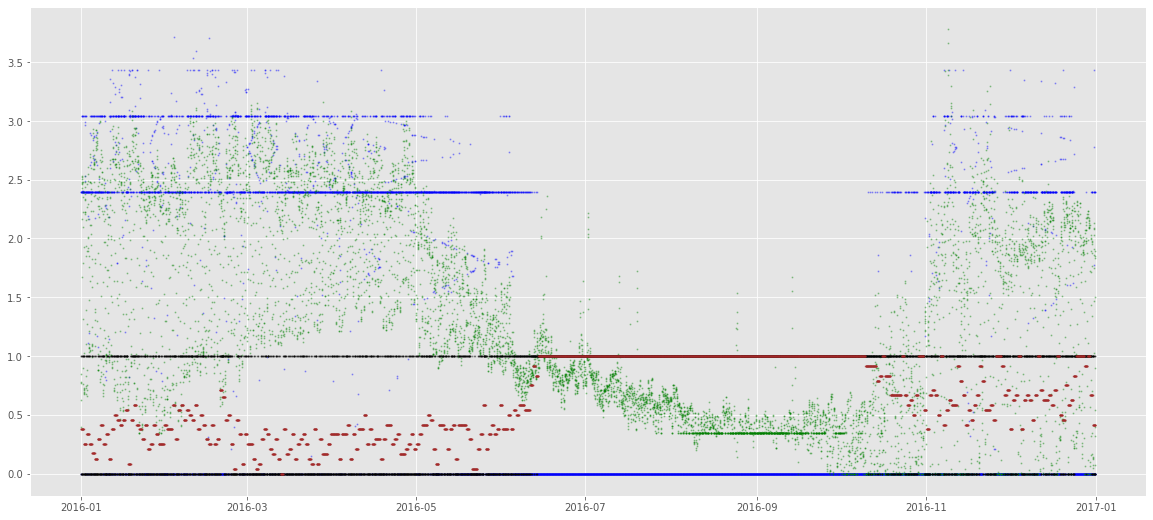

In [14]:
#ГРАФИК ПЛАН-ФАКТ
  plt.figure(figsize=(20,9))
  df['log1p_fact'] = np.log(1+df['meter_reading'])
  df['log1p_plan'] = np.log(1+df['NN_PRED'])
  met = 3
  building_id = 106
  plt.plot( df[(df['meter']==met) & (df['building_id']==building_id)]['timestamp']
          , df[(df['meter']==met) & (df['building_id']==building_id)]['log1p_fact'] , 'ro', markersize = 1   , color = 'blue' ,label = 'Факт', alpha = 0.3)
  plt.plot( df[(df['meter']==met) & (df['building_id']==building_id)]['timestamp']
           , df[(df['meter']==met) & (df['building_id']==building_id)]['log1p_plan'] , 'ro', markersize = 1  , color = 'green',label = 'План', alpha = 0.3)
  plt.plot( df[(df['meter']==met) & (df['building_id']==building_id)]['timestamp']
           , df[(df['meter']==met) & (df['building_id']==building_id)]['is_equal_prev'] , 'ro', markersize = 1  , color = 'black',label = 'Выкинуто', alpha = 0.3)
  plt.plot( df[(df['meter']==met) & (df['building_id']==building_id)]['timestamp']
           , df[(df['meter']==met) & (df['building_id']==building_id)]['IS_BAD_PRCNT'] , 'ro', markersize = 1  , color = 'brown',label = 'Выкинуто', alpha = 0.3)
  plt.show()

In [0]:
#nn_3.save(DIR + str(meter) + 'HANDLY_SAVED.MODEL')
# keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)

-- -- -- -- -- -- -- -- -- Предсказание -- -- -- -- -- -- -- -- --

In [0]:
#Предсказание из 4х значений:
  nn_0 = keras.models.load_model (DIR_SAVE + '0HANDLY_SAVED3best.MODEL')
  nn_1 = keras.models.load_model (DIR_SAVE + '1HANDLY_SAVED3best.MODEL')
  nn_2 = keras.models.load_model (DIR_SAVE + '2HANDLY_SAVED3best.MODEL')
  nn_3 = keras.models.load_model (DIR_SAVE + '3HANDLY_SAVED3best.MODEL')

  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()

  df['NN_PRED'] = 0
  df['NN_PRED_0'] = nn_0.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_1'] = nn_1.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_2'] = nn_2.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_3'] = nn_3.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED'] = np.where(df['meter'] == 0, df['NN_PRED_0'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 1, df['NN_PRED_1'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 2, df['NN_PRED_2'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 3, df['NN_PRED_3'], df['NN_PRED'])
  df.drop(columns = ['NN_PRED_0', 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'], inplace = True)
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

  df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
  df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)

  print( 'Ошибка общая: ', np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))
      , 'Ошибка (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  # print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        )
  # print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        )
  # print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        )

  gc.collect()

In [0]:
#Ошибки:
  Общая:     1.2940425445438188 Ошибка (VAL):   1.3035619563953205 Ошибка (VAL_чист):   0.6154425269032927 Ошибка (VAL_чист2):    0.5166720488706185
  Ошибка 0:  1.1108272200417615 Ошибка 0 (VAL): 1.1039979542354519 Ошибка 0 (VAL_чист): 0.4199684887318391 Ошибка 0 (VAL_чист2):  0.40071672645920714
  Ошибка 1:  1.4674246744239359 Ошибка 1 (VAL): 1.4998371692364791 Ошибка 1 (VAL_чист): 0.7936248109822508 Ошибка 1 (VAL_чист2):  0.6763456453516548
  Ошибка 2:  1.584895359471045 Ошибка 2 (VAL):  1.595279682390636 Ошибка 2 (VAL_чист):  0.8156651059087789 Ошибка 2 (VAL_чист2):  0.6075341541971445
  Ошибка 3:  1.5811641937262615 Ошибка 3 (VAL):  1.6275882770258792 Ошибка 3 (VAL_чист):1.1791615642131834 Ошибка 3 (VAL_чист2):  0.8287557439810707
  0
  Общая  :   1.2383488513622485 Ошибка (VAL):   1.2497646476956246 Ошибка (VAL_чист):    0.5613541671314798 Ошибка (VAL_чист2):    0.4601055341524471
  Ошибка 0:  1.089517078219136 Ошибка 0 (VAL):  1.0830665788767133 Ошибка 0 (VAL_чист):  0.32307141312090654 Ошибка 0 (VAL_чист2): 0.2984998363948374
  Ошибка 1:  1.4093559595246432 Ошибка 1 (VAL): 1.4441371298998904 Ошибка 1 (VAL_чист):  0.7674735069465627 Ошибка 1 (VAL_чист2):  0.6515384132612695
  Ошибка 2:  1.434270799339943 Ошибка 2 (VAL):  1.4459949706379165 Ошибка 2 (VAL_чист):  0.7751574071879366 Ошибка 2 (VAL_чист2):  0.59349123776128
  Ошибка 3:  1.4481746111510552 Ошибка 3 (VAL): 1.5064615354375264 Ошибка 3 (VAL_чист):  1.0977130741767314 Ошибка 3 (VAL_чист2):  0.7436043422326556
  0
  Общая:     1.288451580726024 Ошибка (VAL):     1.2967080663610595 Ошибка (VAL_чист):    0.5559658155345275 Ошибка (VAL_чист2):   0.45027898146764
  Ошибка 0:  1.1135345769523262 Ошибка 0 (VAL):  1.1073602983520954 Ошибка 0 (VAL_чист):  0.30211474219652695 Ошибка 0 (VAL_чист2):0.2760929212947043
  Ошибка 1:  1.4447116762681158 Ошибка 1 (VAL):  1.4773486254929924 Ошибка 1 (VAL_чист):  0.778543934083951 Ошибка 1 (VAL_чист2):  0.6485716599103746
  Ошибка 2:  1.4827505038656164 Ошибка 2 (VAL):  1.4859210115055426 Ошибка 2 (VAL_чист):  0.776992332783179 Ошибка 2 (VAL_чист2):  0.5982294414393752
  Ошибка 3:  1.6852442156559078 Ошибка 3 (VAL):  1.7187446259260037 Ошибка 3 (VAL_чист):  1.0748931586686294 Ошибка 3 (VAL_чист2): 0.726536756006331
  0
  Общая:     1.3473874674637107 Ошибка (VAL):    1.3483415928656848 Ошибка (VAL_чист):    0.5756767405084868 Ошибка (VAL_чист2):   0.4623615327006715
  Ошибка 0:  1.097150680567493 Ошибка 0 (VAL):   1.0891511641164369 Ошибка 0 (VAL_чист):  0.33891800740903766 Ошибка 0 (VAL_чист2):0.3149225188104313
  Ошибка 1:  1.5319581086991891 Ошибка 1 (VAL):  1.5591904765901698 Ошибка 1 (VAL_чист):  0.7038461305727779 Ошибка 1 (VAL_чист2): 0.5850605730802025
  Ошибка 2:  1.6638633608261502 Ошибка 2 (VAL):  1.6575565750506658 Ошибка 2 (VAL_чист):  0.9184081840472923 Ошибка 2 (VAL_чист2): 0.6847327356541326
  Ошибка 3:  1.9625404814033556 Ошибка 3 (VAL):  1.955545484766667 Ошибка 3 (VAL_чист):   1.1170540079900018 Ошибка 3 (VAL_чист2): 0.7521327934769413

In [0]:
#тмп
  pd.set_option('display.max_rows', 500)
  pd.set_option('display.max_columns', 500)
  pd.set_option('display.width', 100)
  warnings.filterwarnings('ignore')
  np.set_printoptions (precision = 4, suppress  = True)

  df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)
  print(len(df), len(df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['IS_BAD_PRCNT']<0.25)]))
  print(df[(df['hour']==14) & (df['meter']==0) & (df['building_id']==1) & (df['IS_BAD_PRCNT']<0.25)][['timestamp','hour','weekday','meter_reading','NN_PRED','NN_ERR','k_NN_ERR']].sort_values('timestamp').head(400))

In [0]:
df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50)  & (df['IS_BAD_PRCNT']<0.25)].describe()

In [0]:
print( np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))     )

1.3473874674637107




**-- -- -- -- -- -- -- -- --РАСЧЁТ НЕЙРОНОК после очистки -- -- -- -- -- -- -- -- --**



In [0]:
#0: electricity, 1: chilledwater, 2: steam, 3: hotwater
# РАСЧЁТ НЕЙРОНОК:
  reg = 0.00001
  batch_size = 2048
  epochs = 30
  meter = 0

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  init = TruncatedNormal(mean=0.0, stddev=0.05, seed=159)
  bias = Constant(value = 0.1)
  
  if 0==0:
    meter = 0
    opt = Adam(lr = 0.001)

    nn_0 = Sequential()
    nn_0.add(Dense(100, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_initializer = 'normal', kernel_regularizer=l2(reg), bias_initializer=bias))
    nn_0.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
    nn_0.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
    nn_0.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
    nn_0.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

    nn_0.compile(optimizer = opt, loss = MALE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
    
    val = df[(df['meter'] == meter) & (df['day']%6 == 0) ]# & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100 & (df['IS_BAD_PRCNT'] < 0.25)]
    #val_2 = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.25)]
    df_cleared = df[(df['day']%6 != 0) & (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['meter'] == meter) & (df['IS_BAD_PRCNT'] < 0.25)][In_Columns + [Out_Columns]]

    hist = nn_0.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                    , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                    ) 
    nn_0.save(DIR_SAVE + str(meter) + 'HANDLY_SAVED_3.MODEL')
    gc.collect()

In [0]:
# 0030 |  TST_loss: 0.2538 TST_MAE_: 0.1651 TST_RMSLE: 0.2388 TST_VAL_: 0.9784 TST_mean_squared_error: 32969.6232 TST_MAPE_: 0.2023 ///  TRN_loss: 0.2828 TRN_MAE_: 0.1912 TRN_RMSLE: 0.2676 TRN_VAL_: 0.8983 TRN_mean_squared_error: 32923.1633 TRN_MAPE_: 0.1969

In [0]:
for lr in [0.001]:
  opt = Adam(lr = lr)
  epochs = 20
  batch_size = 2048
  meter = 0
  nn_0 = keras.models.load_model (DIR + '0HANDLY_SAVED_3best.MODEL')
  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.25)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['day']%6 != 0) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][In_Columns + [Out_Columns]]
  print('*'*9, lr, '*'*33)
  nn_0.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_0.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_0.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

In [0]:
#Предсказание из 4х значений = 0:
  nn_0 = keras.models.load_model (DIR + '0HANDLY_SAVED_3.MODEL')
  #nn_1 = keras.models.load_model (DIR + '1HANDLY_SAVED_3.MODEL')
  #nn_2 = keras.models.load_model (DIR + '2HANDLY_SAVED_3.MODEL')
  #nn_3 = keras.models.load_model (DIR + '3HANDLY_SAVED_3.MODEL')

  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()

  df['NN_PRED'] = 0
  df['NN_PRED_0'] = nn_0.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED_1'] = nn_1.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED_2'] = nn_2.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED_3'] = nn_3.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED'] = np.where(df['meter'] == 0, df['NN_PRED_0'], df['NN_PRED'])
  #df['NN_PRED'] = np.where(df['meter'] == 1, df['NN_PRED_1'], df['NN_PRED'])
  #df['NN_PRED'] = np.where(df['meter'] == 2, df['NN_PRED_2'], df['NN_PRED'])
  #df['NN_PRED'] = np.where(df['meter'] == 3, df['NN_PRED_3'], df['NN_PRED'])
  df.drop(columns = ['NN_PRED_0'], inplace = True) #, 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

  df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
  print( np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))     )
  print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        )
  #print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        )
  #print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        )
  #print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        )
  #df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)
  gc.collect()

In [0]:
Ошибка 0:  1.1024091953998731 Ошибка 0 (VAL):  1.0939318102859754 Ошибка 0 (VAL_чист):  0.2971202786841661 Ошибка 0 (VAL_чист):  0.27036618063814444
0

In [0]:
print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        )
  

Ошибка 0:  1.0967505629134169 Ошибка 0 (VAL):  1.0889958705909204 Ошибка 0 (VAL_чист):  0.29653998158216416


In [0]:
if 1==1:
  reg = 0.00001
  meter = 1
  epochs = 190
  batch_size = 1024
  opt = Adam(lr = 0.001)
  bias = Constant(value = 0.1)

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=15, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_1 = Sequential()
  nn_1.add(Dense(100, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_initializer = 'normal', kernel_regularizer=l2(reg), bias_initializer=bias))
  nn_1.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
  nn_1.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

  nn_1.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  
  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.25)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['day']%6 != 0) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][In_Columns + [Out_Columns]]

  hist = nn_1.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_1.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

In [0]:
for lr in [0.007]:
  opt = Adam(lr = lr)
  epochs = 70
  meter = 1
  batch_size = 720

  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.45)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['day']%6 != 0) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns + [Out_Columns]]

  print('*'*9, lr, '*'*33)
  nn_1.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_1.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_1.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

In [0]:
#Предсказание из 4х значений = 0:
  #nn_0 = keras.models.load_model (DIR + '0HANDLY_SAVED_3.MODEL')
  nn_1 = keras.models.load_model (DIR + '1HANDLY_SAVED_3.MODEL')
  #nn_2 = keras.models.load_model (DIR + '2HANDLY_SAVED_3.MODEL')
  #nn_3 = keras.models.load_model (DIR + '3HANDLY_SAVED_3.MODEL')

  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()

  df['NN_PRED'] = 0
  #df['NN_PRED_0'] = nn_0.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_1'] = nn_1.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED_2'] = nn_2.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED_3'] = nn_3.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED'] = np.where(df['meter'] == 0, df['NN_PRED_0'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 1, df['NN_PRED_1'], df['NN_PRED'])
  #df['NN_PRED'] = np.where(df['meter'] == 2, df['NN_PRED_2'], df['NN_PRED'])
  #df['NN_PRED'] = np.where(df['meter'] == 3, df['NN_PRED_3'], df['NN_PRED'])
  #df.drop(columns = ['NN_PRED_0'], inplace = True) #, 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

  df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
  print( np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))     )
  # print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_PRED']+1),2.00000)))        
  # , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  # , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  # , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        )
  
  print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        )
  
  #print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        )
  #print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        )
  #print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        )
  #df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)
  gc.collect()

4.143660029954269
Ошибка 0:  1.4462519064009887 Ошибка 0 (VAL):  1.4819992377016542 Ошибка 0 (VAL_чист):  0.628029160200588 Ошибка 0 (VAL_чист):  0.4921451933316616


0

In [0]:
Ошибка 0:  1.4622222874555681 Ошибка 0 (VAL):  1.4974377063554198 Ошибка 0 (VAL_чист):  0.6416758062352609 Ошибка 0 (VAL_чист):  0.5087780382284447
Ошибка 0:  1.4513305175601738 Ошибка 0 (VAL):  1.4857607748364132 Ошибка 0 (VAL_чист):  0.6544772099268412 Ошибка 0 (VAL_чист):  0.5241878970208895
Ошибка 0:  1.559959814457174 Ошибка 0 (VAL):  1.5880652782130562 Ошибка 0 (VAL_чист):  0.6931055197830647 Ошибка 0 (VAL_чист):  0.5696662087687516
Ошибка 1:  1.5319581160458586 Ошибка 1 (VAL):  1.5591904792676097 Ошибка 1 (VAL_чист):  0.7038461338617784 Ошибка 1 (VAL_чист2):  0.5850605758832433

In [0]:
if 2==2:
  reg = 0.000001
  meter = 2
  epochs = 80
  batch_size = 700
  opt = Adam(lr = 0.0005)
  bias = Constant(value = 0.1)

  earlyStopping = EarlyStopping(monitor='loss', patience=30, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=55, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_2 = Sequential()
  nn_2.add(Dense(100, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_initializer = 'normal', kernel_regularizer=l2(reg), bias_initializer=bias))
  nn_2.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_2.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
  nn_2.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_2.add(Dense( 1, activation = 'relu', kernel_initializer = 'normal'))

  nn_2.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.45)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns + [Out_Columns]]

  hist = nn_2.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_2.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

In [0]:
for lr in [0.03]:
  nn_2 = keras.models.load_model (DIR + '2HANDLY_SAVED_3best.MODEL')
  opt = Adam(lr = lr)
  epochs = 70
  batch_size = 700
  meter = 2
  bias = Constant(value = 0.1)

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=15, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.45)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['day']%6 != 0) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns + [Out_Columns]]
  print('*'*9, lr, '*'*33)
  nn_0.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_2.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_2.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

In [0]:
if 3==3:
  meter = 3
  epochs = 300
  batch_size = 700
  opt = Adam(lr = 0.007)

  earlyStopping = EarlyStopping(monitor='loss', patience=50, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_3 = Sequential()
  nn_3.add(Dense(100, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_initializer = 'normal', kernel_regularizer=l2(reg), bias_initializer=bias))
  nn_3.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_3.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
  nn_3.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_3.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

  nn_3.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.45)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50)  & (df['day']%6!=0) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns + [Out_Columns]]

  hist = nn_3.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_3.save(DIR + str(meter) + 'HANDLY_SAVED0_3.MODEL')
  gc.collect()

In [0]:
for lr in [0.007]:
  opt = Adam(lr = lr)
  epochs = 200
  batch_size = 700
  meter = 3
  nn_3 = keras.models.load_model (DIR + str(meter) + 'HANDLY_SAVED_3best.MODEL')

  earlyStopping = EarlyStopping(monitor='loss', patience=50, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=12, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.45)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['day']%6 != 0) & (df['k_NN_ERR']>1/50) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns + [Out_Columns]]
  print('*'*9, lr, '*'*33)
  nn_3.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_3.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_3.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

In [0]:
#nn_0.save(DIR + '0HANDLY_SAVED_3best.MODEL')
  # nn_1.save(DIR + '1HANDLY_SAVED_3best.MODEL')
  # nn_2.save(DIR + '2HANDLY_SAVED_3best.MODEL')
  # nn_3.save(DIR + '3HANDLY_SAVED_3best.MODEL')

In [0]:
#Предсказание из 4х значений:
  nn_0 = keras.models.load_model (DIR_SAVE + '0HANDLY_SAVED_3best.MODEL')
  nn_1 = keras.models.load_model (DIR_SAVE + '1HANDLY_SAVED_3best.MODEL')
  nn_2 = keras.models.load_model (DIR_SAVE + '2HANDLY_SAVED_3best.MODEL')
  nn_3 = keras.models.load_model (DIR_SAVE + '3HANDLY_SAVED_3best.MODEL')

  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()

  df['NN_PRED'] = 0
  df['NN_PRED_0'] = nn_0.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_1'] = nn_1.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_2'] = nn_2.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_3'] = nn_3.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED'] = np.where(df['meter'] == 0, df['NN_PRED_0'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 1, df['NN_PRED_1'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 2, df['NN_PRED_2'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 3, df['NN_PRED_3'], df['NN_PRED'])
  df.drop(columns = ['NN_PRED_0', 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'], inplace = True)
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

  df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
  df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)

  print( 'Ошибка общая: ', np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))
      , 'Ошибка (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  # print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        )
  # print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        )
  # print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        )

  gc.collect()

In [0]:
#Ошибки:
  Ошибка общая:  1.3332699709812266 Ошибка (VAL):  1.337540194067479 Ошибка (VAL_чист):  0.5418592287241801 Ошибка (VAL_чист2):  0.40073096858305257
  Ошибка 0:  1.098206407152078 Ошибка 0 (VAL):  1.0905813857988798 Ошибка 0 (VAL_чист):  0.28240200416498673 Ошибка 0 (VAL_чист2):  0.2562246375809472
  Ошибка 1:  1.4462519064009887 Ошибка 1 (VAL):  1.4819992377016542 Ошибка 1 (VAL_чист):  0.628029160200588 Ошибка 1 (VAL_чист2):  0.47946068818401355
  Ошибка 2:  1.6966445281141582 Ошибка 2 (VAL):  1.6978240187666451 Ошибка 2 (VAL_чист):  0.926254557141954 Ошибка 2 (VAL_чист2):  0.6472006361307439
  Ошибка 3:  1.9577298686058777 Ошибка 3 (VAL):  1.9537862377808086 Ошибка 3 (VAL_чист):  1.1455655044777464 Ошибка 3 (VAL_чист2):  0.6972188121146171

  Ошибка общая:  1.3473873510158345 Ошибка (VAL):  1.3483414756663568 Ошибка (VAL_чист):  0.5756767186919248 Ошибка (VAL_чист2):  0.462361504102313
  Ошибка 0:  1.0971504229404558 Ошибка 0 (VAL):  1.0891509074774033 Ошибка 0 (VAL_чист):  0.3389179667173395 Ошибка 0 (VAL_чист2):  0.3149224768996143
  Ошибка 1:  1.5319581160458586 Ошибка 1 (VAL):  1.5591904792676097 Ошибка 1 (VAL_чист):  0.7038461338617784 Ошибка 1 (VAL_чист2):  0.5850605758832433
  Ошибка 2:  1.6638634087676607 Ошибка 2 (VAL):  1.6575566177087862 Ошибка 2 (VAL_чист):  0.918408148629441 Ошибка 2 (VAL_чист2):  0.6847326774214916
  Ошибка 3:  1.9625404709477796 Ошибка 3 (VAL):  1.9555454713909437 Ошибка 3 (VAL_чист):  1.117054007408267 Ошибка 3 (VAL_чист2):  0.7521327942946583

In [0]:
#Evaluate:
  score = nn_0.evaluate(df[df['meter']==0][In_Columns], df[df['meter']==0][Out_Columns], verbose=1, batch_size = 30000)
  print(0)
  for i in range(len(nn_0.metrics_names)):
    print("%s: %.2f%%" % (nn_0.metrics_names[i], score[i]*100))

  score = nn_1.evaluate(df[df['meter']==1][In_Columns], df[df['meter']==1][Out_Columns], verbose=1, batch_size = 30000)
  print(1)
  for i in range(len(nn_1.metrics_names)):
    print("%s: %.2f%%" % (nn_1.metrics_names[i], score[i]*100))

  score = nn_2.evaluate(df[df['meter']==2][In_Columns], df[df['meter']==2][Out_Columns], verbose=1, batch_size = 30000)
  print(2)
  for i in range(len(nn_2.metrics_names)):
    print("%s: %.2f%%" % (nn_2.metrics_names[i], score[i]*100))

  score = nn_3.evaluate(df[df['meter']==3][In_Columns], df[df['meter']==3][Out_Columns], verbose=1, batch_size = 30000)
  print(3)
  for i in range(len(nn_3.metrics_names)):
    print("%s: %.2f%%" % (nn_3.metrics_names[i], score[i]*100))
  
  gc.collect()

In [15]:
#Важность показателей 0
  from sklearn.utils import shuffle
  nn = keras.models.load_model (DIR_SAVE + '0HANDLY_SAVED3.MODEL')
  meter = 0
  val = df[(df['meter']==meter) & (df['day']%6==0)  & (df['IS_BAD_PRCNT']<0.45)]
  #Подставить нужную нейронку в зависимости от meter
  #print(nn.metrics_names)
  k = pd.DataFrame( [nn.evaluate(val[In_Columns], val[Out_Columns], batch_size = 800000, verbose = 0)],columns=nn.metrics_names)
  k['name'] = '---INITIAL---'
  tmp_out=k.copy()
  for i in range(len(In_Columns)):
      X_val_2 = val[In_Columns].copy()
      s = shuffle(X_val_2.iloc[:,i])
      s.index = X_val_2.index
      X_val_2.iloc[:, i] = s
      tmp = pd.DataFrame([nn.evaluate(X_val_2, val[Out_Columns], batch_size = 800000, verbose = 0)], columns = nn.metrics_names)-k[nn.metrics_names] 
      tmp['name'] = In_Columns[i]
      tmp_out = pd.concat([tmp_out, tmp])
      X_val_2 = None
      gc.collect()
  tmp_out.set_index('name', inplace = True)
  pd.set_option('display.float_format', lambda x: '%.4f' % x)
  print (tmp_out[nn.metrics_names].sort_values('RMSLE', ascending=False))

                                 loss    MAE_   RMSLE    VAL_  mean_squared_error  MAPE_
name                                                                                    
building_meter_weekday_median  1.3044  0.8968  1.3044  0.0166         110792.3814 1.3744
---INITIAL---                  0.4485  0.2023  0.4286  0.8940          27978.6406 0.3121
square_feet                    0.3032  0.1100  0.3032 -0.0005           7444.3530 0.2812
site_id                        0.1321  0.0714  0.1321  0.0071           3328.3561 0.1481
primary_use_ID                 0.1100  0.0486  0.1100 -0.0039           2546.8816 0.1116
hour_cos                       0.0649  0.0389  0.0649  0.0016           1493.1166 0.0678
building_meter_hour_median     0.0453  0.0085  0.0453  0.0029            245.6533 0.0705
week_sin                       0.0309  0.0130  0.0309 -0.0082            511.5756 0.0175
week_cos                       0.0307  0.0136  0.0307 -0.0150            831.1489 0.0146
air_temperature      

In [0]:
#Важность показателей 1
  from sklearn.utils import shuffle
  nn = keras.models.load_model (DIR_SAVE + '1HANDLY_SAVED3.MODEL')
  meter = 1
  val = df[(df['meter']==meter) & (df['day']%6==0)  & (df['IS_BAD_PRCNT']<0.25)]
  #Подставить нужную нейронку в зависимости от meter
  #print(nn.metrics_names)
  k = pd.DataFrame( [nn.evaluate(val[In_Columns], val[Out_Columns], batch_size = 800000, verbose = 0)],columns=nn.metrics_names)
  k['name'] = '---INITIAL---'
  tmp_out=k.copy()
  for i in range(len(In_Columns)):
      X_val_2 = val[In_Columns].copy()
      s = shuffle(X_val_2.iloc[:,i])
      s.index = X_val_2.index
      X_val_2.iloc[:, i] = s
      tmp = pd.DataFrame([nn.evaluate(X_val_2, val[Out_Columns], batch_size = 800000, verbose = 0)], columns = nn.metrics_names)-k[nn.metrics_names] 
      tmp['name'] = In_Columns[i]
      tmp_out = pd.concat([tmp_out, tmp])
      X_val_2 = None
      gc.collect()
  tmp_out.set_index('name', inplace = True)
  pd.set_option('display.float_format', lambda x: '%.4f' % x)
  print (tmp_out[nn.metrics_names].sort_values('RMSLE', ascending=False))

In [0]:
#Важность показателей 2
  from sklearn.utils import shuffle
  nn = keras.models.load_model (DIR_SAVE + '2HANDLY_SAVED3.MODEL')
  meter = 2
  val = df[(df['meter']==meter) & (df['day']%6==0)  & (df['IS_BAD_PRCNT']<0.25)]
  #Подставить нужную нейронку в зависимости от meter
  #print(nn.metrics_names)
  k = pd.DataFrame( [nn.evaluate(val[In_Columns], val[Out_Columns], batch_size = 800000, verbose = 0)],columns=nn.metrics_names)
  k['name'] = '---INITIAL---'
  tmp_out=k.copy()
  for i in range(len(In_Columns)):
      X_val_2 = val[In_Columns].copy()
      s = shuffle(X_val_2.iloc[:,i])
      s.index = X_val_2.index
      X_val_2.iloc[:, i] = s
      tmp = pd.DataFrame([nn.evaluate(X_val_2, val[Out_Columns], batch_size = 800000, verbose = 0)], columns = nn.metrics_names)-k[nn.metrics_names] 
      tmp['name'] = In_Columns[i]
      tmp_out = pd.concat([tmp_out, tmp])
      X_val_2 = None
      gc.collect()
  tmp_out.set_index('name', inplace = True)
  pd.set_option('display.float_format', lambda x: '%.4f' % x)
  print (tmp_out[nn.metrics_names].sort_values('RMSLE', ascending=False))

In [0]:
#Важность показателей 3
  from sklearn.utils import shuffle
  nn = keras.models.load_model (DIR_SAVE + '3HANDLY_SAVED03.MODEL')
  meter = 3
  val = df[(df['meter']==meter) & (df['day']%6==0)  & (df['IS_BAD_PRCNT']<0.25)]
  #Подставить нужную нейронку в зависимости от meter
  #print(nn.metrics_names)
  k = pd.DataFrame( [nn.evaluate(val[In_Columns], val[Out_Columns], batch_size = 800000, verbose = 0)],columns=nn.metrics_names)
  k['name'] = '---INITIAL---'
  tmp_out=k.copy()
  for i in range(len(In_Columns)):
      X_val_2 = val[In_Columns].copy()
      s = shuffle(X_val_2.iloc[:,i])
      s.index = X_val_2.index
      X_val_2.iloc[:, i] = s
      tmp = pd.DataFrame([nn.evaluate(X_val_2, val[Out_Columns], batch_size = 800000, verbose = 0)], columns = nn.metrics_names)-k[nn.metrics_names] 
      tmp['name'] = In_Columns[i]
      tmp_out = pd.concat([tmp_out, tmp])
      X_val_2 = None
      gc.collect()
  tmp_out.set_index('name', inplace = True)
  pd.set_option('display.float_format', lambda x: '%.4f' % x)
  print (tmp_out[nn.metrics_names].sort_values('RMSLE', ascending=False))

In [0]:
ИДЕИ:
  1) Сделать не показатель, а его отклонение от медианы по строению/дню/часу
  2) 


In [5]:
#reduce_mem_usage(df_test)
gc.collect()
#df_test.describe()

0

In [16]:
# Подготовка данных тест:
  df_test = pd.read_csv(DIR + "test.csv", engine = 'python')
  print('Забрали с диска')
  df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

  df_test['hour_cos'] = np.cos(df_test['timestamp'].dt.hour * 2. * np.pi / 24.)
  df_test['hour_sin'] = np.sin(df_test['timestamp'].dt.hour * 2. * np.pi / 24.)

  df_test['weekday_cos'] = np.cos(df_test['timestamp'].dt.weekday * 2. * np.pi / 7.)
  df_test['weekday_sin'] = np.sin(df_test['timestamp'].dt.weekday * 2. * np.pi / 7.)

  df_test['week_cos'] = np.cos(df_test['timestamp'].dt.week * 2. * np.pi / 53.)
  df_test['week_sin'] = np.sin(df_test['timestamp'].dt.week * 2. * np.pi / 53.)

  #reduce_mem_usage(df_test)
  gc.collect()

Забрали с диска


91

In [17]:
# Добавление медианы по метрике постройки
  df_median = df.groupby(by=['building_id','meter'])['building_meter_median'].median()
  df_test = pd.merge(df_test, df_median, how = 'left', on = ['building_id','meter'])
  del df_median 
  gc.collect()
  print('Построены медианы по сооружению')
# Добавление медианы по часу, по неделе, метрике постройки
  df_test['hour'] = df_test['timestamp'].dt.hour
  df_median = df.groupby(by=['building_id','hour','meter'])['building_meter_hour_median'].median()
  #df_median.name = 'building_meter_hour_median'
  # df_mean = df.groupby (by=['building_id','hour','meter']) ['meter_reading'].mean()
  # df_mean.name = 'building_meter_hour_mean'
  # df_median = pd.merge(df_median, df_mean, how = 'inner', on = ['building_id','hour','meter'])
  #df_median['building_meter_hour_median'] = (df_median['building_meter_hour_median'] * 9.000000 + df_median['building_meter_hour_mean'])/10.000000
  #print(len(df_test))

  # df_median2 = df[df['IS_BAD_PRCNT']<0.75].groupby(by=['building_id','hour','meter'])['meter_reading'].median()
  # df_median2.name = 'building_meter_hour_median_all'
  # df_mean2 = df[df['IS_BAD_PRCNT']<0.75].groupby (by=['building_id','hour','meter']) ['meter_reading'].mean()
  # df_mean2.name = 'building_meter_hour_mean_all'
  # df_median2 = pd.merge(df_median2, df_mean2, how = 'inner', on = ['building_id','hour','meter'])
  # df_median2['building_meter_hour_median_all'] = (df_median2['building_meter_hour_median_all'] * 9.000000 + df_median2['building_meter_hour_mean_all'])/10.000000
  # df_median2.drop(columns=['building_meter_hour_mean_all'], inplace = True)
  # df_median = pd.merge(df_median, df_median2, how = 'left', on = ['building_id','hour','meter'])
  
  # df_median['building_meter_hour_median'] = np.where(df_median['building_meter_hour_median_all'] >= 0, df_median['building_meter_hour_median_all'], df_median['building_meter_hour_median'])
  # #print(len(df_test))

  # df_median.drop(columns=['building_meter_hour_median_all'], inplace = True)
  # df_median2 = df[df['IS_BAD_PRCNT']<0.45].groupby(by=['building_id','hour','meter'])['meter_reading'].median()
  # df_median2.name = 'building_meter_hour_median_45'
  # df_mean2 = df[df['IS_BAD_PRCNT']<0.45].groupby (by=['building_id','hour','meter']) ['meter_reading'].mean()
  # df_mean2.name = 'building_meter_hour_mean_45'
  # df_median2 = pd.merge(df_median2, df_mean2, how = 'inner', on = ['building_id','hour','meter'])
  # df_median2['building_meter_hour_median_45'] = (df_median2['building_meter_hour_median_45'] * 9.000000 + df_median2['building_meter_hour_mean_45'])/10.000000
  # df_median2.drop(columns=['building_meter_hour_mean_45'], inplace = True)
  # df_median = pd.merge(df_median, df_median2, how = 'left', on = ['building_id','hour','meter'])
  
  # df_median['building_meter_hour_median'] = np.where(df_median['building_meter_hour_median_45'] >= 0, df_median['building_meter_hour_median_45'], df_median['building_meter_hour_median'])
  # df_median.drop(columns=['building_meter_hour_median_45'], inplace = True)

  df_test = pd.merge(df_test, df_median, how = 'left', on = ['building_id','hour','meter'])
  
  #print(len(df_test))
  del df_median #, df_mean, df_median2, df_mean2

  gc.collect()
  #df_test['k_fact_med_hour']=np.exp( np.abs( np.log( (df_test['meter_reading']+0.01)/(df_test['building_meter_hour_median']+0.01)) ) )
  
  df_test['weekday'] = df_test['timestamp'].dt.weekday
  df_median = df.groupby(by=['building_id','weekday','meter'])['building_meter_weekday_median'].median()
  #df_median.name = 'building_meter_weekday_median'
  df_test = pd.merge(df_test, df_median, how = 'left', on = ['building_id','weekday','meter'])
  del df_median 
  #print(len(df_test))

  print('Построены медианы по сооружению/часу')
  holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                    "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                    "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                    "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                    "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                    "2019-01-01"]
  df_test["is_holiday"] = (df_test.timestamp.isin(holidays)).astype(int)
  del holidays
  gc.collect()
  #print(len(df_test))
# Подстановка параметров сооружения
  df_median = df.groupby(by=['building_id'])['primary_use_ID','site_id','square_feet'].median()
  df_test = pd.merge(df_test, df_median, how = 'left', on = ['building_id'])
  del df_median 

  # building_df = pd.read_csv(DIR + "building_metadata.csv", engine = 'python')
  # from sklearn.preprocessing import LabelEncoder
  # le = LabelEncoder()
  # building_df["primary_use_ID"] = le.fit_transform(building_df["primary_use"])
  # #building_df['floor_count'].fillna(1, inplace= True)
  # #building_df['year_built'].fillna(2000, inplace= True)

  # #building_df['primary_use'] = building_df['primary_use'].astype('category')
  # #building_df = pd.get_dummies(building_df)

  # df_test = df_test.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
  # del building_df
  print('Подставлены данные по сооружению')
  gc.collect()
  #print(len(df_test))

Построены медианы по сооружению
Построены медианы по сооружению/часу
Подставлены данные по сооружению


0

In [0]:
del df
#del tmp
gc.collect()

In [0]:
#Вставка данных погоды
#Восстановление пустых данных погоды через соседей по линейной инетрполяции
  df_weather = pd.read_csv(DIR + "weather_test.csv", engine = 'python')
  df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
  df_weather.drop(columns = ['precip_depth_1_hr'], inplace = True)
  gc.collect()

  #weather_train.groupby('site_id').apply(lambda group: group.isna().sum())
  df_times = df_test.drop_duplicates(['site_id','timestamp'])[['site_id','timestamp']]
  df_times = pd.merge(df_times, df_weather, how = 'left', on = ['site_id','timestamp'])
  df_times.sort_values(by = ['site_id','timestamp'], inplace = True)
  gc.collect()

  df_times = df_times.groupby('site_id'  ).apply(lambda group: group.interpolate(limit_direction='both'))
  df_times = df_times.groupby('timestamp').apply(lambda group: group.interpolate(limit_direction='both'))
  
  df_test = pd.merge(df_test, df_times, how = 'left', on = ['site_id','timestamp'])
  del df_weather, df_times

  #del df_weather

In [13]:
#reduce_mem_usage(df_test)
df_test.to_feather(DIR_SAVE + 'DF_TEST_REDUCED3.FTHR')
gc.collect()

0

In [0]:
#df_test = pd.read_feather(DIR_SAVE + 'DF_TEST_REDUCED3.FTHR')
#gc.collect()

import pickle
with open(DIR_SAVE+'scaler31.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    In_Columns = pickle.load(handle)
    Out_Columns = pickle.load(handle)

In [14]:
# Нормализация
i=0
print(scaler.data_max_)
for c in In_Columns:
  if c in ['building_meter_median','building_meter_hour_median','building_meter_weekday_median','primary_use_ID','site_id','square_feet']:
    print(i, c, 'Уже нормализовано:', scaler.scale_[i],scaler.min_[i], '     ',scaler.data_min_[i], scaler.data_max_[i])
  else:
    print(i, c, scaler.scale_[i],scaler.min_[i], '     ', scaler.data_min_[i], scaler.data_max_[i])
    df_test[c] = df_test[c] * scaler.scale_[i] + scaler.min_[i]
  i+=1
  gc.collect()

[     1.         1.         1.         0.975      1.         1.
     15.    875000.        15.         1.        47.2        9.
     26.1     1045.5      360.        19.    517184.943 573294.611
  41437.5  ]
0 hour_cos 0.5 0.5 -1.0 1.0
1 hour_sin 0.5 0.5 -1.0 1.0
2 weekday_cos 0.5260475418008436 0.47395245819915655 -0.9009688679024191 1.0
3 weekday_sin 0.512858431636277 0.5 -0.9749279121818236 0.9749279121818236
4 week_cos 0.5004394529575549 0.4995605470424452 -0.9982437317643215 1.0
5 week_sin 0.5002196782202569 0.49999999999999994 -0.9995608365087943 0.9995608365087943
6 site_id Уже нормализовано: 0.06666666666666667 0.0 0.0 15.0
7 square_feet Уже нормализовано: 1.1432268950986433e-06 -0.00032353321131291604 283.0 875000.0
8 primary_use_ID Уже нормализовано: 0.06666666666666667 0.0 0.0 15.0
9 is_holiday 1.0 0.0 0.0 1.0
10 air_temperature 0.01314060446780552 0.37976346911957953 -28.9 47.2
11 cloud_coverage 0.1111111111111111 0.0 0.0 9.0
12 dew_temperature 0.016366612111292964 0.572831

In [24]:
# Выбор нейронок:
  nn_0 = keras.models.load_model (DIR_SAVE + '0HANDLY_SAVED3best.MODEL')
  nn_1 = keras.models.load_model (DIR_SAVE + '1HANDLY_SAVED3best.MODEL')
  nn_2 = keras.models.load_model (DIR_SAVE + '2HANDLY_SAVED3best.MODEL')
  nn_3 = keras.models.load_model (DIR_SAVE + '3HANDLY_SAVED3best.MODEL')
  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()

348

In [25]:
#Предсказание из 4х значений:
  df_test['NN_PRED'] = 0 
  df_test['NN_PRED']  = df_test['NN_PRED'].astype('float32')
  l = len(df_test)
  print( len(df_test) )
  step = 1600000
  for i in range(int(l/step)+1):
    print(i*step, (i+1)*step)
    tmp = df_test[i*step: (i+1)*step][In_Columns + ['row_id','meter']]
    gc.collect() 
    tmp['NN_PRED'] = 0 
    tmp['NN_PRED_0'] = nn_0.predict(tmp[In_Columns], batch_size = 20000) 
    tmp['NN_PRED_1'] = nn_1.predict(tmp[In_Columns], batch_size = 20000) 
    tmp['NN_PRED_2'] = nn_2.predict(tmp[In_Columns], batch_size = 20000) 
    tmp['NN_PRED_3'] = nn_3.predict(tmp[In_Columns], batch_size = 20000) 
    gc.collect()
    tmp['NN_PRED'] = np.where(tmp['meter'] == 0, tmp['NN_PRED_0'], tmp['NN_PRED'])
    tmp['NN_PRED'] = np.where(tmp['meter'] == 1, tmp['NN_PRED_1'], tmp['NN_PRED'])
    tmp['NN_PRED'] = np.where(tmp['meter'] == 2, tmp['NN_PRED_2'], tmp['NN_PRED'])
    tmp['NN_PRED'] = np.where(tmp['meter'] == 3, tmp['NN_PRED_3'], tmp['NN_PRED'])
    gc.collect()
    #print('спрогнозили')
    #df_test[i*step: (i+1)*step]['NN_PRED'] = pd.merge(df_test, tmp[['row_id','NN_PRED']], how = 'left', on = ['row_id'])
    #df_test.loc[i*step: (i+1)*step, 'NN_PRED'] = tmp['NN_PRED']
    
    if i==0:
      a = tmp[['row_id','NN_PRED', 'meter']].copy()
    else:
      a = pd.concat([a, tmp[['row_id','NN_PRED', 'meter']].copy()], sort=False)
    #del tmp
    #gc.collect() 

41697600
0 1600000
1600000 3200000
3200000 4800000
4800000 6400000
6400000 8000000
8000000 9600000
9600000 11200000
11200000 12800000
12800000 14400000
14400000 16000000
16000000 17600000
17600000 19200000
19200000 20800000
20800000 22400000
22400000 24000000
24000000 25600000
25600000 27200000
27200000 28800000
28800000 30400000
30400000 32000000
32000000 33600000
33600000 35200000
35200000 36800000
36800000 38400000
38400000 40000000
40000000 41600000
41600000 43200000


In [26]:
print(len(df_test))
#a.drop_duplicates(inplace =True)
#print(len(a))

41697600


In [0]:
a['row_id']         = a['row_id'].astype('Int32')
a['meter_reading']  = a['NN_PRED'].astype('float32')
a[['row_id', 'meter_reading']].to_csv(DIR_SAVE+'OUT_Ver0.31 no clean_4.csv', index = False)

In [28]:
a.head(-1)

,row_id,NN_PRED,meter,meter_reading
0,0,252.3435,0,252.3435
1,1,138.7939,0,138.7939
2,2,21.5660,0,21.5660
3,3,346.3572,0,346.3572
4,4,962.0777,0,962.0777
...,...,...,...,...
41697594,41697594,115.1817,0,115.1817
41697595,41697595,25.0976,0,25.0976
41697596,41697596,24.4483,0,24.4483
41697597,41697597,20.8425,0,20.8425


In [29]:
a.groupby(['meter'])['NN_PRED'].agg(['mean','median', 'min', 'max'])

,mean,median,min,max
meter,,,,
0,188.5150,121.4338,0.0000,1289.6725
1,1118.4012,1157.1016,0.0000,2033.0570
2,19150.7862,3308.5892,0.0000,4419279.5000
3,4392.8502,2594.4308,0.0000,44600.5234


In [54]:
df.groupby(['meter'])['meter_reading'].agg(['mean','median', 'min', 'max'])

,mean,median,min,max
meter,,,,
0,162.707,68.000,0.000,79769.000
1,633.801,120.698,0.000,880374.000
2,14402.644,253.150,0.000,21904700.000
3,374.154,38.099,0.000,160187.000


In [56]:
df.groupby(['meter'])['NN_PRED'].agg(['mean','median', 'min', 'max'])

,mean,median,min,max
meter,,,,
0,158.798,74.755,0.000,1289.670
1,378.482,138.774,0.000,2033.057
2,11507.809,244.696,0.000,17275218.000
3,269.547,40.498,0.000,45745.234


In [5]:
df.describe()
air_temperature
is_holiday
cloud_coverage
dew_temperature
sea_level_pressure	
wind_direction	
wind_speed

,building_id,meter,meter_reading,hour_cos,hour_sin,weekday_cos,weekday_sin,week_cos,week_sin,meter_reading_prev,is_equal_prev,day,IS_BAD_PRCNT,building_meter_median,building_meter_mean,building_meter_mean_45,hour,building_meter_hour_median,building_meter_hour_mean,k_fact_med_hour,weekday,building_meter_weekday_median,is_holiday,site_id,square_feet,year_built,floor_count,primary_use_ID,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948183.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18293583.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,18948184.000,6974756.000,2358476.000,18948184.000,18948184.000,18948184.000,18948184.000,18078918.000,18948184.000,18948184.000,18948184.000
mean,801.974,0.676,2232.996,0.500,0.500,0.472,0.498,0.488,0.493,2232.996,0.161,185.601,0.161,0.001,2232.996,2575.451,11.502,0.001,2232.996,23368.884,3.007,0.009,0.001,0.541,0.121,1969.248,4.052,0.220,0.595,0.316,0.685,0.984,0.620,0.470,0.175
std,440.083,0.934,158278.578,0.354,0.354,0.372,0.363,0.352,0.355,158278.582,0.367,105.237,0.314,0.022,82117.057,85395.660,6.922,0.024,82265.539,1023290.661,1.997,0.039,0.034,0.348,0.127,31.279,3.071,0.231,0.144,0.306,0.178,7.683,0.091,0.314,0.118
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1900.000,1.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000
25%,357.000,0.000,20.707,0.146,0.146,0.000,0.099,0.140,0.131,20.707,0.000,97.000,0.000,0.000,38.634,47.025,6.000,0.000,35.973,1.083,1.000,0.001,0.000,0.200,0.038,1951.000,1.000,0.000,0.497,0.000,0.548,0.000,0.563,0.194,0.111
50%,918.000,0.000,83.000,0.500,0.500,0.357,0.500,0.455,0.470,83.000,0.000,186.000,0.000,0.000,109.848,127.470,12.000,0.000,107.921,1.274,3.000,0.002,0.000,0.600,0.083,1970.000,4.000,0.200,0.606,0.222,0.702,0.000,0.620,0.472,0.163
75%,1200.000,1.000,272.860,0.854,0.854,0.802,0.901,0.837,0.848,272.860,0.000,277.000,0.125,0.001,307.502,358.264,18.000,0.001,305.962,1.978,5.000,0.006,0.000,0.867,0.157,1999.000,6.000,0.400,0.700,0.500,0.827,0.000,0.675,0.750,0.242
max,1448.000,3.000,21904700.000,1.000,1.000,1.000,1.000,1.000,1.000,21904700.000,1.000,366.000,1.000,1.000,3813882.148,3866686.396,23.000,1.000,4138801.770,57329462.143,6.000,1.000,1.000,1.000,1.000,2017.000,16.000,1.000,1.000,1.000,1.000,343.000,1.000,1.000,1.000


In [30]:
df_test.describe()

,row_id,building_id,meter,hour_cos,hour_sin,weekday_cos,weekday_sin,week_cos,week_sin,building_meter_median,hour,building_meter_hour_median,weekday,building_meter_weekday_median,is_holiday,primary_use_ID,site_id,square_feet,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed,NN_PRED
count,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000,41697600.0000
mean,20848799.5000,807.5824,0.6643,0.5000,0.5000,0.4751,0.4995,0.4913,0.5000,0.0013,11.5000,0.0014,3.0000,0.0088,0.0001,0.2105,0.5391,0.1219,-0.0003,0.1318,12.2029,13.7401,19.5723,0.6340,0.0000
std,12037060.4366,429.7680,0.9278,0.3536,0.3536,0.3722,0.3625,0.3508,0.3566,0.0215,6.9222,0.0236,2.0034,0.0375,0.0023,0.2301,0.3423,0.1327,0.0000,0.1338,6.3944,0.0915,9.9943,0.0308,0.0000
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0003,0.0000,-10.6000,13.1524,0.0000,0.5728,0.0000
25%,10424399.7500,404.7500,0.0000,0.1464,0.1464,0.0000,0.0990,0.1405,0.1516,0.0001,5.7500,0.0001,1.0000,0.0005,0.0000,0.0000,0.2000,0.0365,-0.0003,0.0178,7.6000,13.6999,11.2593,0.6131,0.0000
50%,20848799.5000,900.0000,0.0000,0.5000,0.5000,0.3569,0.5000,0.5144,0.5000,0.0002,11.5000,0.0002,3.0000,0.0020,0.0000,0.0667,0.6000,0.0823,-0.0003,0.0978,12.4000,13.7472,20.2222,0.6307,0.0000
75%,31273199.2500,1194.2500,1.0000,0.8536,0.8536,0.8019,0.9010,0.8373,0.8484,0.0006,17.2500,0.0006,5.0000,0.0061,0.0000,0.4000,0.8667,0.1579,-0.0003,0.2133,17.0667,13.7922,27.4074,0.6514,0.0000
max,41697599.0000,1448.0000,3.0000,1.0000,1.0000,1.0000,1.0000,0.9965,1.0000,1.0000,23.0000,1.0000,6.0000,1.0000,0.0667,1.0000,1.0000,1.0000,-0.0003,0.6000,26.7000,14.0407,40.0000,0.9689,0.0000


In [0]:
show_plot(hist) 

In [0]:
nn = load_model(DIR, 'model_nn')
opt = Adam(lr = 0.05)
nn.compile(optimizer = opt, loss = mse)
